## Module 1 : Fetch Data

In [4]:
# Import modules
# Read data
import os
import sys
import pickle

# Dataframes
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import concat
# display and formatting
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy.optimize import curve_fit
import numpy.polynomial.polynomial as poly

# Config
folder = './data/'
train = 'train_aWnotuB.csv'
test = 'test_BdBKkAj_L87Nc3S.csv'
sub = 'sample_submission_KVKNmI7.csv'


def _ReadCsv_pd(datafolder, file):
    """Read CSV file from remote path.
    Returns:
      The contents of CSV file.
    Raises:
      ValueError: Unable to read file
    """
    try:
        df = pd.read_csv(os.path.join(datafolder, file))
        print(file, ": Read csv to dataframe sucessfully")
        print("Shape of dataframe", df.shape, "Memory Usage", sys.getsizeof(df))
    except Exception as e:
        raise type(e)(e)
        exit()
    return(df)


# df_copy = df.copy()

def __GetTimeSeriesCount(df, col_name):
    try:
        print(pd.concat(g for _, g in df.groupby() if len(g) > 1))
        
    except:
        print("Dataframe is single timeseries")
    return()


def __SetColumnNames(df, id_col, ds_col, target_col):
    df.rename(columns={ds_col: 'ds', id_col : 'ID', target_col : 'y'}, inplace=True)
#     df.set_index('ds', drop = False, inplace = True)
    return(df)

# Fix in train
train = _ReadCsv_pd(folder, train)
__GetTimeSeriesCount(train,"DateTime")
df = __SetColumnNames(train, id_col = 'ID', ds_col = 'DateTime', target_col = 'Vehicles')

#Fix in test
test = _ReadCsv_pd(folder, test)
__GetTimeSeriesCount(test,"DateTime")
test = __SetColumnNames(test, id_col = 'ID', ds_col = 'DateTime', target_col = 'Vehicles')

df.head()


train_aWnotuB.csv : Read csv to dataframe sucessfully
Shape of dataframe (48120, 4) Memory Usage 4812160
Dataframe is single timeseries
test_BdBKkAj_L87Nc3S.csv : Read csv to dataframe sucessfully
Shape of dataframe (11808, 3) Memory Usage 1086496
Dataframe is single timeseries


,ds,Junction,y,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [5]:
cap_dict = {1: 156+30, 2: 48+30, 3: 180+30, 4: 36+30}

df["cap"] = df['Junction'].map(hdict)
test['cap'] = test['Junction'].map(hdict)

flr = df.y.min()
df['floor'] = flr
test['floor'] = flr
print (df)

                        ds  Junction   y           ID  cap  floor
0      2015-11-01 00:00:00         1  15  20151101001  156      1
1      2015-11-01 01:00:00         1  13  20151101011  156      1
2      2015-11-01 02:00:00         1  10  20151101021  156      1
3      2015-11-01 03:00:00         1   7  20151101031  156      1
4      2015-11-01 04:00:00         1   9  20151101041  156      1
...                    ...       ...  ..          ...  ...    ...
48115  2017-06-30 19:00:00         4  11  20170630194   36      1
48116  2017-06-30 20:00:00         4  30  20170630204   36      1
48117  2017-06-30 21:00:00         4  16  20170630214   36      1
48118  2017-06-30 22:00:00         4  22  20170630224   36      1
48119  2017-06-30 23:00:00         4  12  20170630234   36      1

[48120 rows x 6 columns]


## Module 2 : Clean Data

In [6]:
def __GetIntCols(df, collist):
    for col in collist:
        df[col] = df[col].str.extract('(\d+)').astype(float)
    return(df)

def get_prop_missing_values(df):
    print("Null info in data: ", df.isna().any().sum())
    #prop_missing = round((df[df.columns[:]].isnull().sum()/df[df.columns[:]].count())*100,4)
    prop_missing = round((df.isnull().sum()/len(df))*100,2)
    print("These are the missing values proportions in each column")
    print(prop_missing)
    return()


def __SetColumnTypes(df, change_to_int_list = ['col1']):
    cols = df.columns
    try:
        df = __GetIntCols(df, change_to_int_list)
    except:
        pass
    # Check for any null values in the data
    print("% Missing data in each column \n",get_prop_missing_values(df))
    return(df, cols)


# For this particular dataframe

df['ds'] = pd.to_datetime(df['ds'])
clean_df, cols = __SetColumnTypes(df)

# Get list of column by types
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(cols) - set(num_cols))
cat_cols.remove('ds')
print(cat_cols)

Null info in data:  0
These are the missing values proportions in each column
ds         0.00
Junction   0.00
y          0.00
ID         0.00
cap        0.00
floor      0.00
dtype: float64
% Missing data in each column 
 ()
[]


In [7]:
def __CheckMissingTimeSteps(dfs, group_col):
    tdf = pd.DataFrame({'date': pd.date_range(start='2015-11-01 00:00:00', end='2017-06-30 23:00:00', freq='H')})
    len_tdf = len(tdf)
    vals = dfs[group_col].unique()
    for i in vals:
        if len(dfs[dfs[group_col] == i]) == len_tdf:
            print("No missing timesteps for group", i)
        else:
            print("Missing timesteps for group", i)
            print("Group len VS Timesteps")
            print(len(dfs[dfs[group_col] == i]), len_tdf)
    return()

__CheckMissingTimeSteps(clean_df, group_col='Junction')

#Since we see missing timesteps in group 4, we checked and found that group4 started at later date. Checking again:

def __CheckMissingTimeSteps(dfs, group_col):
    tdf = pd.DataFrame({'date': pd.date_range(start='2017-01-01 00:00:00', end='2017-06-30 23:00:00', freq='H')})
    len_tdf = len(tdf)
    vals = dfs[group_col].unique()
    for i in vals:
        if len(dfs[dfs[group_col] == i]) == len_tdf:
            print("No missing timesteps for group", i)
        else:
            print("Missing timesteps for group", i)
            print("Group len VS Timesteps")
            print(len(dfs[dfs[group_col] == i]), len_tdf)
    return()

__CheckMissingTimeSteps(clean_df[clean_df['Junction'] == 4], group_col='Junction')

No missing timesteps for group 1
No missing timesteps for group 2
No missing timesteps for group 3
Missing timesteps for group 4
Group len VS Timesteps
4344 14592
No missing timesteps for group 4


()

## Module 3 : Pre-Proccess Model Data

In [8]:
# Helper functions
# Split dataframe
def __SplitTrainTest(X, prop = 0.95):
    '''Takes in the dataframe and proprtion of train size and returns the train and test sets'''
    X.sort_values(by='ds', ascending=True, inplace = True)
    train_size = int(len(X) * prop)
    train, test = X[0:train_size], X[train_size:len(X)]
    print("Min date train main", train.ds.min(), "Max date train main", train.ds.max())
    print("Min date test main", test.ds.min(), "Max date test main", test.ds.max())
    print("Length of train", len(train), "Length of test", len(test))
    return(train, test)


train_df, test_df = __SplitTrainTest(clean_df, prop = 0.80)

Min date train main 2015-11-01 00:00:00 Max date train main 2017-03-22 17:00:00
Min date test main 2017-03-22 18:00:00 Max date test main 2017-06-30 23:00:00
Length of train 38496 Length of test 9624


## Module 4 : Exploratory Data Analysis

Distribution for
a
Cat col not found


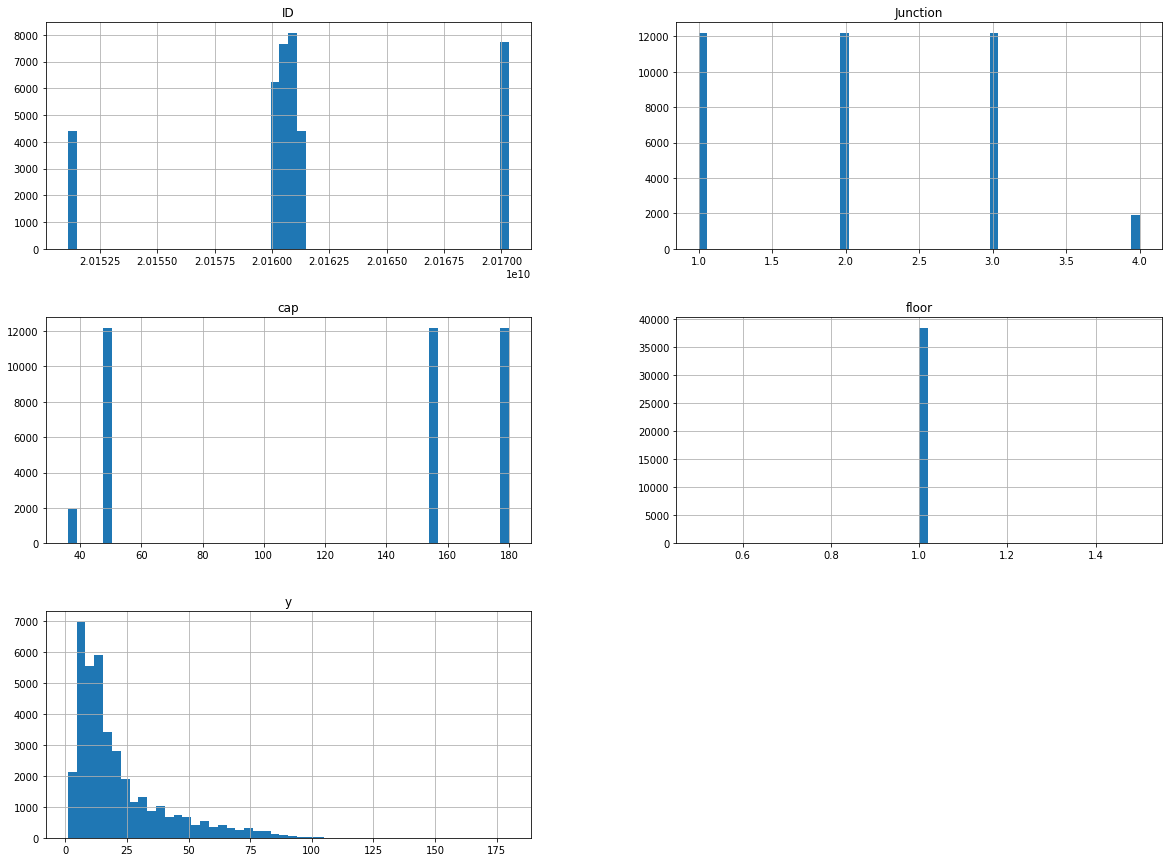

,Junction,y,ID,cap,floor
count,38496.00,38496.00,38496.00,38496.00,38496.00
mean,2.10,21.17,20161503534.75,123.37,1.00
std,0.91,18.43,5290818.03,59.45,0.00
min,1.00,1.00,20151101001.00,36.00,1.00
25%,1.00,9.00,20160313159.00,48.00,1.00
50%,2.00,15.00,20160725077.00,156.00,1.00
75%,3.00,27.00,20161205425.00,180.00,1.00
max,4.00,180.00,20170322174.00,180.00,1.00


In [9]:
def __ExploringDataframe(df, cat_list= ['a']):
    try:
        for col in cat_list:
            print("Distribution for")
            print(col)
            print(df[col].value_counts())
    except:
        print("Cat col not found")
    # Above data as plots
    df.hist(bins=50, figsize=(20,15))
    plt.show()
    return()

__ExploringDataframe(train_df)

# Lets look at the rest of the fields - we can check out the numeric data using describe method
train_df.describe()

## Module 5 : Prepare Model Data

In [10]:
def __PrepModelDf(model_df):
    df = model_df.copy()
    df.set_index('ds', drop = False, inplace = True)
    df_id = df["ID"].copy()
    df = df.drop(["ID"], axis = 1)
    df = df.drop(["Junction"], axis = 1)
    return(df, df_id)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def __GetError(test, forecast):
    actual = pd.Series(test['y'])
    actual = actual.tolist()
    predictions = forecast['yhat']
    forecast['actual'] = actual
    min_val = min(actual)
    forecast['yhat'] = np.where(forecast['yhat'] < 0, min_val, forecast['yhat'])
    mape = mean_absolute_percentage_error(actual, forecast['yhat'])
    print(mape)
    return(forecast)


def __PlotPrediction(train, test, forecast):
    fig = plt.figure(facecolor='w', figsize=(20, 6))
    plt.plot(train.ds, train.y,  label='Train')
    plt.plot(test.ds, test.y,  label='Test')
    plt.plot(test.ds, forecast['yhat'],  label='Predicted')
    plt.show()
    return()


## Module 6: Train Model

In [26]:
tr_i = train_df[train_df['Junction'] == 1]
ts_i = test_df[test_df['Junction'] == 1]
tr_i

,ds,Junction,y,ID,cap,floor
0,2015-11-01 00:00:00,1,15,20151101001,156,1
1,2015-11-01 01:00:00,1,13,20151101011,156,1
2,2015-11-01 02:00:00,1,10,20151101021,156,1
3,2015-11-01 03:00:00,1,7,20151101031,156,1
4,2015-11-01 04:00:00,1,9,20151101041,156,1
...,...,...,...,...,...,...
12181,2017-03-22 13:00:00,1,85,20170322131,156,1
12182,2017-03-22 14:00:00,1,95,20170322141,156,1
12183,2017-03-22 15:00:00,1,94,20170322151,156,1
12184,2017-03-22 16:00:00,1,87,20170322161,156,1


In [29]:
tr_i = train_df[train_df['Junction'] == 1]
ts_i = test_df[test_df['Junction'] == 1]

# Prep Data
tr_df, tr_id = __PrepModelDf(tr_i)
ts_df, ts_id = __PrepModelDf(ts_i)

print("Shape of train", tr_df.shape, "Shape of test", ts_df.shape)
#Fit model
m1 = Prophet(growth='logistic')
m1.fit(tr_df)


from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m1, initial='100 days', period='60 days', horizon = '80 days')
print(df_cv.head())




INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Shape of train (12186, 4) Shape of test (2406, 4)


INFO:fbprophet:Making 6 forecasts with cutoffs between 2016-03-07 17:00:00 and 2017-01-01 17:00:00


                   ds  yhat  yhat_lower  yhat_upper   y              cutoff
0 2016-03-07 18:00:00 40.78       34.49       46.55  39 2016-03-07 17:00:00
1 2016-03-07 19:00:00 41.57       35.62       47.64  40 2016-03-07 17:00:00
2 2016-03-07 20:00:00 41.95       36.74       47.96  42 2016-03-07 17:00:00
3 2016-03-07 21:00:00 41.79       36.03       47.50  38 2016-03-07 17:00:00
4 2016-03-07 22:00:00 40.89       34.91       46.39  25 2016-03-07 17:00:00


In [31]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p = df_p[-80:]
df_p.tail()

# forecast = m1.predict(ts_df)

,horizon,mse,rmse,mae,mape,mdape,coverage
1724,79 days 20:00:00,148.62,12.19,9.60,0.21,0.16,0.52
1725,79 days 21:00:00,149.58,12.23,9.64,0.22,0.16,0.52
1726,79 days 22:00:00,150.40,12.26,9.68,0.22,0.16,0.52
1727,79 days 23:00:00,150.71,12.28,9.69,0.22,0.16,0.52
1728,80 days 00:00:00,151.05,12.29,9.72,0.22,0.16,0.51


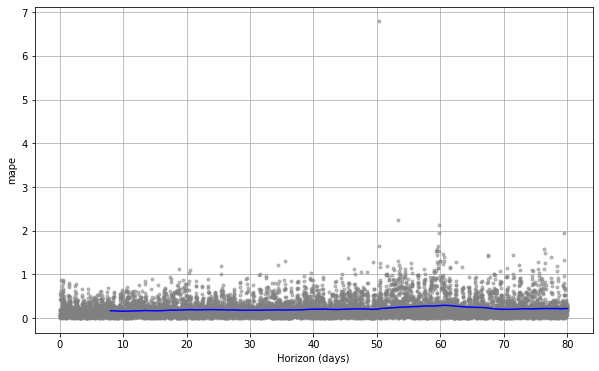

In [34]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [35]:
from fbprophet.plot import add_changepoints_to_plot

In [39]:
ts_df[['ds','y']].head()

,ds,y
ds,,
2017-03-22 18:00:00,2017-03-22 18:00:00,91
2017-03-22 19:00:00,2017-03-22 19:00:00,101
2017-03-22 20:00:00,2017-03-22 20:00:00,98
2017-03-22 21:00:00,2017-03-22 21:00:00,96
2017-03-22 22:00:00,2017-03-22 22:00:00,91


In [43]:
t2 = ts_df[['y']].rename(columns={'y': 'TEST SET'})

,TEST SET
ds,
2017-03-22 18:00:00,91
2017-03-22 19:00:00,101
2017-03-22 20:00:00,98
2017-03-22 21:00:00,96
2017-03-22 22:00:00,91
...,...
2017-06-30 19:00:00,105
2017-06-30 20:00:00,96
2017-06-30 21:00:00,90


,TRAINING SET
ds,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9
...,...
2017-03-22 13:00:00,85
2017-03-22 14:00:00,95
2017-03-22 15:00:00,94


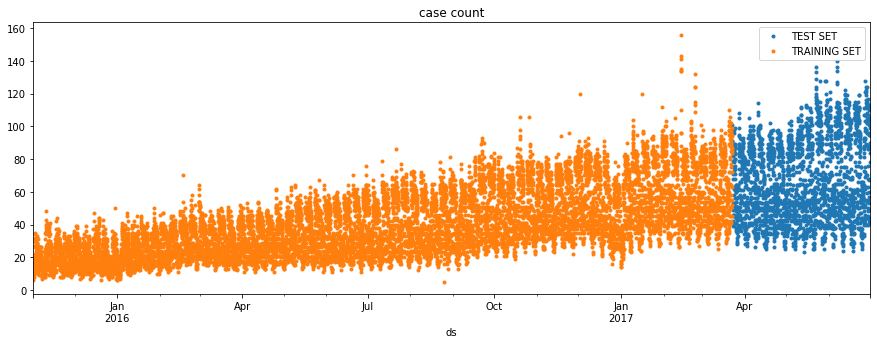

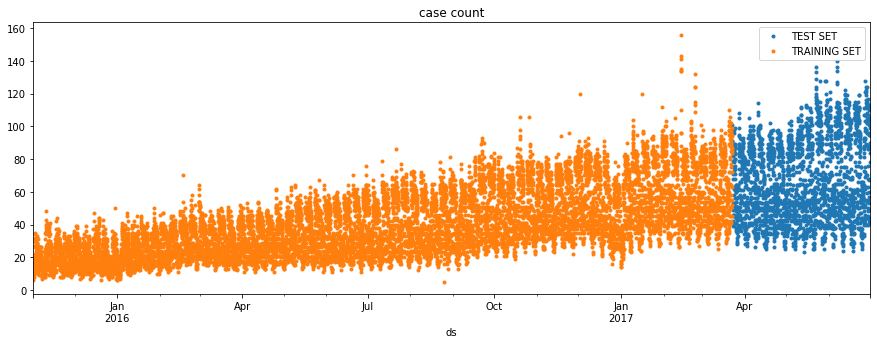

INFO:fbprophet:Making 2 forecasts with cutoffs between 2016-11-07 17:00:00 and 2016-12-22 17:00:00


MAPE CV  21.407116821958816


In [50]:

from fbprophet.plot import add_changepoints_to_plot
pd.plotting.register_matplotlib_converters()

tr_i = train_df[train_df['Junction'] == 1]
ts_i = test_df[test_df['Junction'] == 1]

# Prep Data
tr_df, tr_id = __PrepModelDf(tr_i)
ts_df, ts_id = __PrepModelDf(ts_i)

t1 = tr_df[['y']].rename(columns={'y': 'TRAINING SET'})
t2 = ts_df[['y']].rename(columns={'y': 'TEST SET'})

t2.join(t1,how='outer').plot(figsize=(15,5), title='case count', style='.')
plt.show()

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
params={}
#     params_2={}

model=Prophet(**params)

params={'growth':'logistic','seasonality_mode':'additive','yearly_seasonality':True,'weekly_seasonality':True,'daily_seasonality':True}
model = Prophet(**params).add_seasonality(name='monthly',period=30.5,fourier_order=5)\
    .add_seasonality(name='yearly',period=365.25,fourier_order=5)\
    .add_seasonality(name='quarter',period=365.25/4,fourier_order=5).add_seasonality(name='sem',period=365.25/2,fourier_order=5)\
.add_seasonality(name='weekly',period=7,fourier_order=5).add_seasonality(name='s1',period=365.25/8,fourier_order=5).add_seasonality(name='weekly 1',period=5,fourier_order=5)


model.fit(tr_df)
ts_df_p = model.predict(df=ts_df)
          
cv = cross_validation(model,horizon = '90 days')
print('MAPE CV ',mean_absolute_percentage_error(y_true=cv.y,y_pred=cv.yhat))




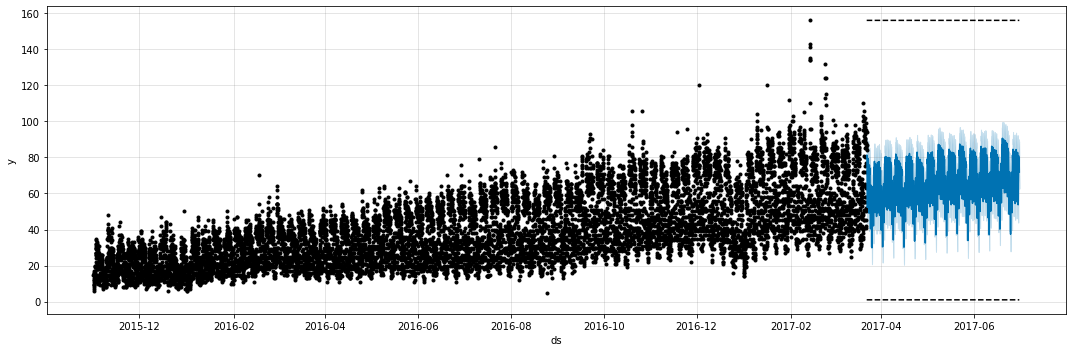

MAPE ERROR 18.008210321597616


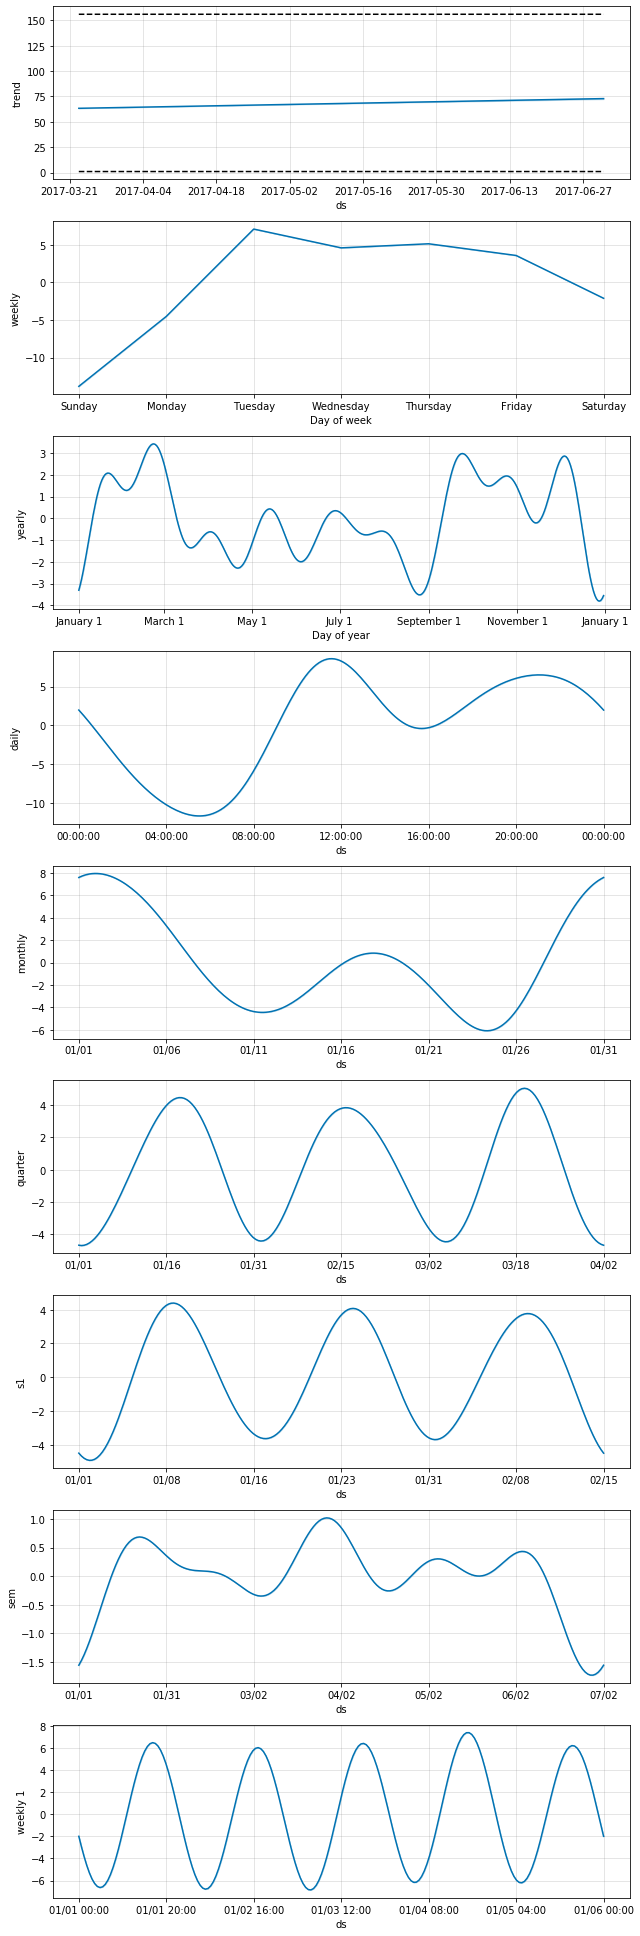

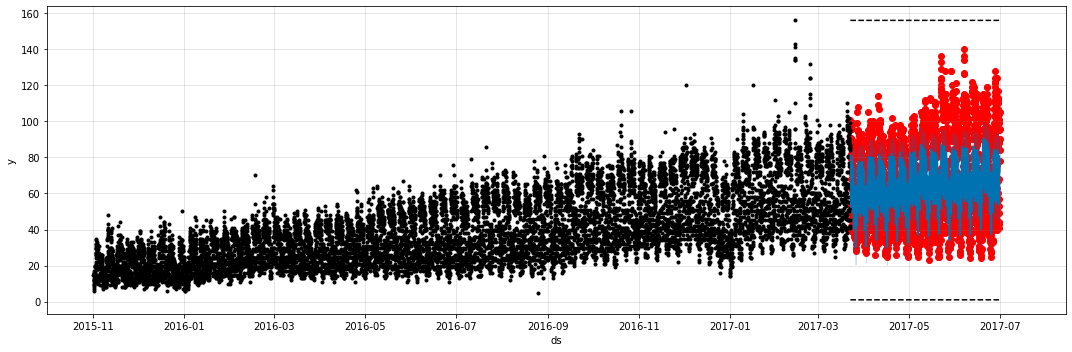

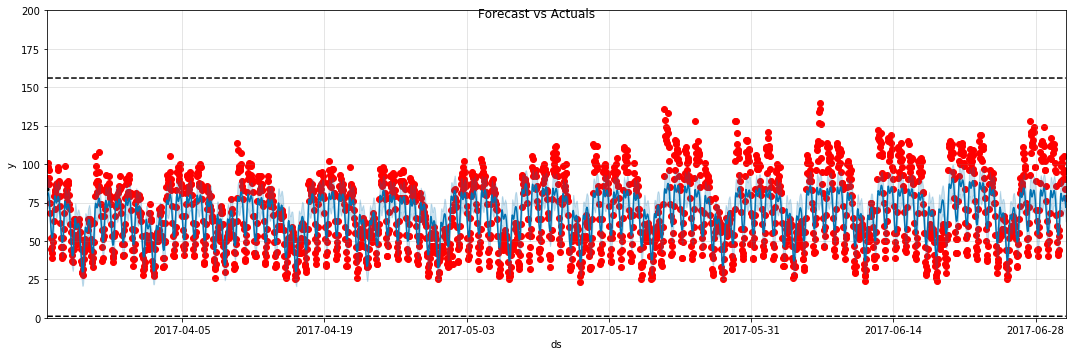

In [55]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(ts_df_p,ax=ax)
plt.show()

fig = model.plot_components(ts_df_p)

# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_df.index, ts_df['y'], color='r')
fig = model.plot(ts_df_p, ax=ax)


# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(ts_df.index, ts_df['y'], color='r')
fig = model.plot(ts_df_p, ax=ax)
ax.set_xbound(lower=ts_df.index.min(),upper=ts_df.index.max())
ax.set_ylim(0, 200)
plot = plt.suptitle('Forecast vs Actuals')
print('MAPE ERROR',mean_absolute_percentage_error(y_true=ts_df['y'],y_pred=ts_df_p['yhat']))


In [22]:
from fbprophet import Prophet

def __ProphetFit(train, test):
    '''Fits the prophet model on '''

    ls = []
#     for Cntry in data_grp.Country.unique().tolist():
    for i in train.Junction.unique().tolist():
        print(i)
        tr_i = train[train['Junction'] == i]
        ts_i = test[test['Junction'] == i]
        
        # Prep Data
        tr_df, tr_id = __PrepModelDf(tr_i)
        ts_df, ts_id = __PrepModelDf(ts_i)
        
        print("Shape of train", tr_df.shape, "Shape of test", ts_df.shape)
        #Fit model
        m1 = Prophet(growth='logistic')
        m1.fit(tr_df)


        forecast = m1.predict(ts_df)
        print("Model trained")
        # Plots
        # fig1 = m1.plot(forecast)
        # fig2 = m1.plot_components(forecast)
        try:
            forecast_df = __GetError(ts_df, forecast)
            __PlotPrediction(tr_df, ts_df, forecast_df)
        except:
            print("Predicting for actual test data")
            forecast_df = pd.DataFrame(forecast)
        
        forecast_df['ID'] = list(ts_id)
        forecast_df['Junction'] = i
        print("Shape of forecast_df", forecast_df.shape)
        
        try:
            forecast_df = forecast_df[['ID', 'actual', 'yhat']]
        except:
            print("Predicting for actual test data")
            forecast_df = forecast_df[['ID', 'yhat']]
        forecast_df.rename(columns={'yhat': 'Vehicles'}, inplace=True)
        
        ls.append(forecast_df)
        
    print("Got predictions for all Junctions")
    out_df = pd.concat(ls)
    print(mean_absolute_percentage_error(out_df.actual, out_df.Vehicles))
    return(out_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1
Shape of train (12186, 4) Shape of test (2406, 4)
Model trained
19.472053368115567


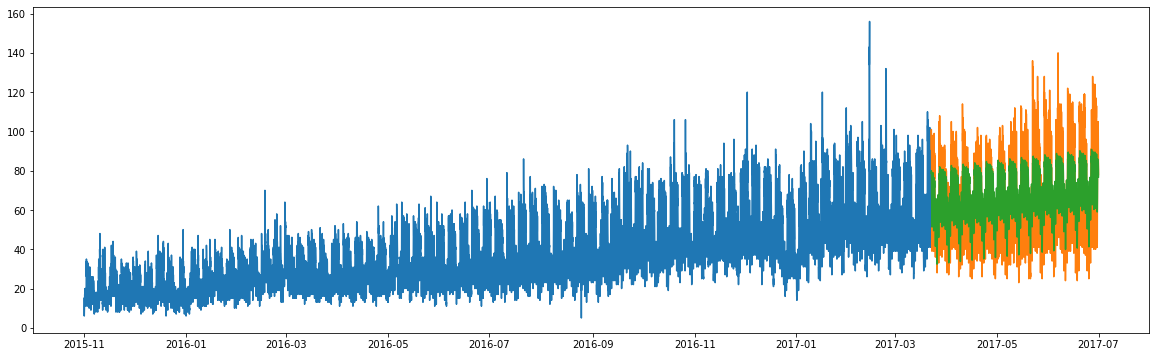

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Shape of forecast_df (2406, 24)
2
Shape of train (12186, 4) Shape of test (2406, 4)
Model trained
27.841896694240344


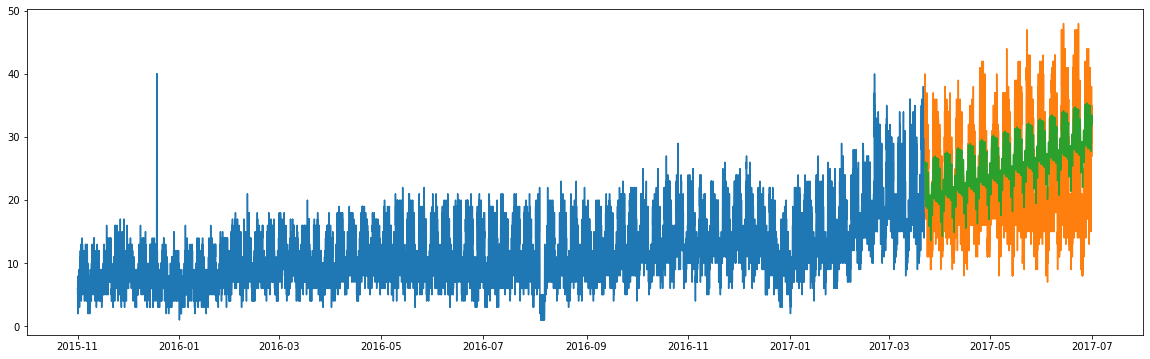

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Shape of forecast_df (2406, 24)
3
Shape of train (12186, 4) Shape of test (2406, 4)
Model trained
44.86838468805709


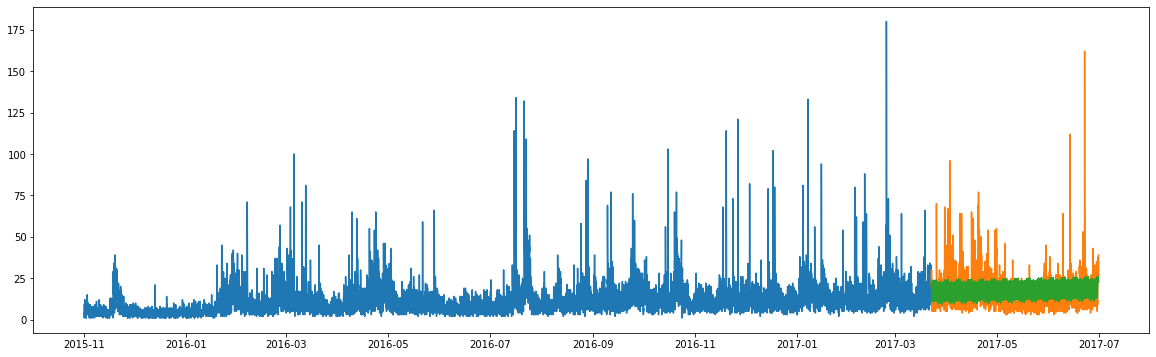

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Shape of forecast_df (2406, 24)
4
Shape of train (1938, 4) Shape of test (2406, 4)
Model trained
38.90357089436954


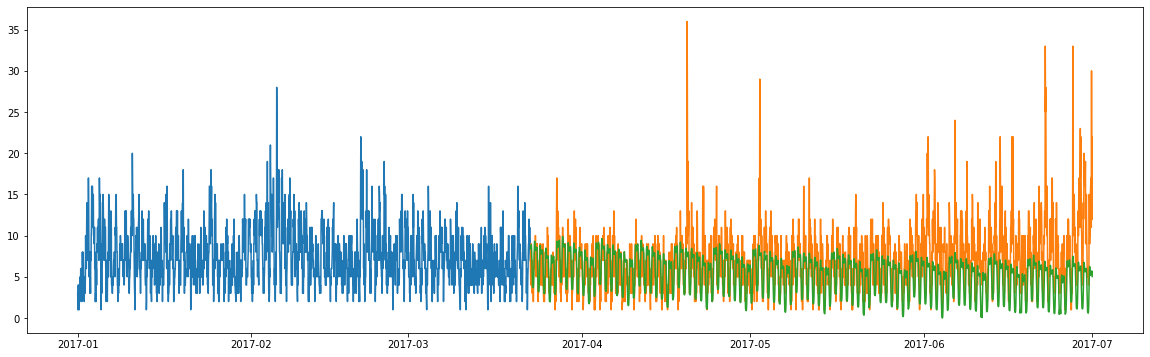

Shape of forecast_df (2406, 24)
Got predictions for all Junctions


In [23]:
test_forecasted_df = __ProphetFit(train_df, test_df)

In [24]:
test_forecasted_df.head()

,ID,actual,Vehicles
0,20170322181,91,78.62
1,20170322191,101,79.79
2,20170322201,98,79.94
3,20170322211,96,79.04
4,20170322221,91,77.06


32.771476411195636

## Module 7 : Fit Trained Model

In [14]:
#Full test data
test.head()

,ds,Junction,ID,cap,floor
0,2017-07-01 00:00:00,1,20170701001,156,1
1,2017-07-01 01:00:00,1,20170701011,156,1
2,2017-07-01 02:00:00,1,20170701021,156,1
3,2017-07-01 03:00:00,1,20170701031,156,1
4,2017-07-01 04:00:00,1,20170701041,156,1


In [15]:


print("Junctions predict for test", test.Junction.unique())
print("Dates to predict for test", test.ds.min(), test.ds.max())

Junctions predict for test [1 2 3 4]
Dates to predict for test 2017-07-01 00:00:00 2017-10-31 23:00:00


In [16]:
predict_df = __ProphetFit(clean_df, test)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1
Shape of train (14592, 4) Shape of test (2952, 3)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Model trained
Predicting for actual test data
Shape of forecast_df (2952, 23)
2
Shape of train (14592, 4) Shape of test (2952, 3)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Model trained
Predicting for actual test data
Shape of forecast_df (2952, 23)
3
Shape of train (14592, 4) Shape of test (2952, 3)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Model trained
Predicting for actual test data
Shape of forecast_df (2952, 23)
4
Shape of train (4344, 4) Shape of test (2952, 3)
Model trained
Predicting for actual test data
Shape of forecast_df (2952, 23)
Got predictions for all Junctions


In [17]:
len(predict_df)

11808

In [18]:
len(predict_df)

11808

In [19]:
predict_df.head()

,ID,Vehicles
0,20170701001,70.69
1,20170701011,64.52
2,20170701021,58.29
3,20170701031,53.02
4,20170701041,49.32


## Module 8 : Predict

In [20]:
sub_df = _ReadCsv_pd(folder, sub)
sub_df.head()

sample_submission_KVKNmI7.csv : Read csv to dataframe sucessfully
Shape of dataframe (11808, 2) Memory Usage 189088


,ID,Vehicles
0,20170701001,50
1,20170701011,50
2,20170701021,50
3,20170701031,50
4,20170701041,50


In [21]:
output_directory = "./submissions/"
predict_df.to_csv(output_directory + "ruhama_submission5.csv", index=False)